In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip -o jena_climate_2009_2016.csv.zip

--2024-04-07 23:21:36--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.170.72, 16.182.67.16, 16.182.43.56, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.170.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.2’

100%[======================================>] 13,565,642  24.5MB/s   in 0.5s   

2024-04-07 23:21:37 (24.5 MB/s) - ‘jena_climate_2009_2016.csv.zip.2’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

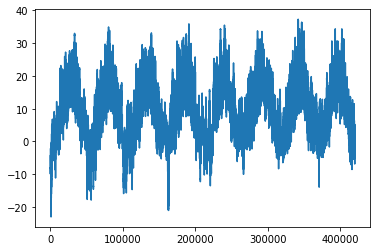

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

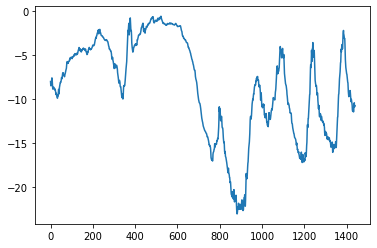

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 11s 13ms/step - loss: 12.4253 - mae: 2.7302 - val_loss: 10.0899 - val_mae: 2.5112
INFO:tensorflow:Assets written to: jena_dense.x/assets
Epoch 2/5
819/819 [==============================] - 10s 12ms/step - loss: 9.1846 - mae: 2.3890 - val_loss: 10.1098 - val_mae: 2.5156
Epoch 3/5
819/819 [==============================] - 10s 12ms/step - loss: 8.4582 - mae: 2.2946 - val_loss: 11.3884 - val_mae: 2.6815
Epoch 4/5
819/819 [==============================] - 10s 12ms/step - loss: 7.9845 - mae: 2.2280 - val_loss: 13.1420 - val_mae: 2.8607
Epoch 5/5
405/405 [==============================] - 3s 7ms/step - loss: 10.9803 - mae: 2.6094
Test MAE: 2.61


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x) # Tried different dense units of 8, 32, 64 apart from 16 which is given in actual code
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 11s 12ms/step - loss: 12.3436 - mae: 2.7233 - val_loss: 13.8701 - val_mae: 2.9547
INFO:tensorflow:Assets written to: jena_dense.x/assets
Epoch 2/5
819/819 [==============================] - 11s 13ms/step - loss: 8.5287 - mae: 2.2892 - val_loss: 11.3542 - val_mae: 2.6583
INFO:tensorflow:Assets written to: jena_dense.x/assets
Epoch 3/5
819/819 [==============================] - 10s 12ms/step - loss: 7.4531 - mae: 2.1421 - val_loss: 11.0132 - val_mae: 2.6213
INFO:tensorflow:Assets written to: jena_dense.x/assets
Epoch 4/5
819/819 [==============================] - 10s 12ms/step - loss: 6.7848 - mae: 2.0485 - val_loss: 10.5261 - val_mae: 2.5702
INFO:tensorflow:Assets written to: jena_dense.x/assets
Epoch 5/5
405/405 [==============================] - 4s 8ms/step - loss: 11.6319 - mae: 2.6929
Test MAE: 2.69


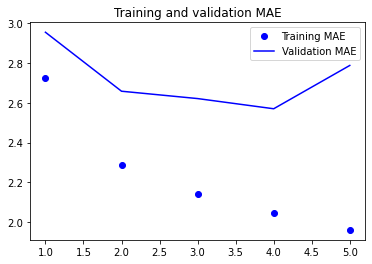

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
conv_x = layers.Conv1D(8, 24, activation="relu")(inputs)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 12, activation="relu")(conv_x)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 6, activation="relu")(conv_x)
conv_x = layers.GlobalAveragePooling1D()(conv_x)
outputs = layers.Dense(1)(conv_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.conv_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.conv_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 27s 32ms/step - loss: 24.0226 - mae: 3.7768 - val_loss: 15.9132 - val_mae: 3.1675
INFO:tensorflow:Assets written to: jena_conv.conv_x/assets
Epoch 2/5
819/819 [==============================] - 26s 31ms/step - loss: 15.8685 - mae: 3.1715 - val_loss: 15.7589 - val_mae: 3.1164
INFO:tensorflow:Assets written to: jena_conv.conv_x/assets
Epoch 3/5
819/819 [==============================] - 25s 31ms/step - loss: 14.7748 - mae: 3.0570 - val_loss: 14.3187 - val_mae: 2.9769
INFO:tensorflow:Assets written to: jena_conv.conv_x/assets
Epoch 4/5
819/819 [==============================] - 26s 31ms/step - loss: 13.8690 - mae: 2.9573 - val_loss: 18.3764 - val_mae: 3.3883
Epoch 5/5
405/405 [==============================] - 5s 12ms/step - loss: 16.2496 - mae: 3.1836
Test MAE: 3.18


In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 46s 54ms/step - loss: 36.3901 - mae: 4.3898 - val_loss: 11.9013 - val_mae: 2.6387


INFO:tensorflow:Assets written to: jena_lstm.x/assets


INFO:tensorflow:Assets written to: jena_lstm.x/assets


Epoch 2/5
819/819 [==============================] - 44s 54ms/step - loss: 10.8027 - mae: 2.5557 - val_loss: 9.7721 - val_mae: 2.4276


INFO:tensorflow:Assets written to: jena_lstm.x/assets


INFO:tensorflow:Assets written to: jena_lstm.x/assets


Epoch 3/5
819/819 [==============================] - 40s 49ms/step - loss: 9.7146 - mae: 2.4217 - val_loss: 10.3641 - val_mae: 2.5002
Epoch 4/5
819/819 [==============================] - 42s 51ms/step - loss: 9.4040 - mae: 2.3801 - val_loss: 10.1752 - val_mae: 2.4656
Epoch 5/5
405/405 [==============================] - 6s 14ms/step - loss: 11.2803 - mae: 2.6360
Test MAE: 2.64


In [17]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [18]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [21]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
lstm_x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
lstm_x = layers.Dropout(0.5)(lstm_x)
outputs = layers.Dense(1)(lstm_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.lstm_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.lstm_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 75s 90ms/step - loss: 47.5539 - mae: 5.1383 - val_loss: 13.7328 - val_mae: 2.8058
INFO:tensorflow:Assets written to: jena_lstm_dropout.lstm_x/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout.lstm_x/assets


Epoch 2/5
819/819 [==============================] - 73s 89ms/step - loss: 20.1743 - mae: 3.4537 - val_loss: 10.4901 - val_mae: 2.5313
INFO:tensorflow:Assets written to: jena_lstm_dropout.lstm_x/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout.lstm_x/assets


Epoch 3/5
819/819 [==============================] - 73s 89ms/step - loss: 18.3109 - mae: 3.2980 - val_loss: 10.0192 - val_mae: 2.4784
INFO:tensorflow:Assets written to: jena_lstm_dropout.lstm_x/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout.lstm_x/assets


Epoch 4/5
819/819 [==============================] - 72s 88ms/step - loss: 17.5332 - mae: 3.2244 - val_loss: 9.5882 - val_mae: 2.4277
INFO:tensorflow:Assets written to: jena_lstm_dropout.lstm_x/assets


INFO:tensorflow:Assets written to: jena_lstm_dropout.lstm_x/assets


Epoch 5/5
405/405 [==============================] - 5s 12ms/step - loss: 11.1563 - mae: 2.6144
Test MAE: 2.61


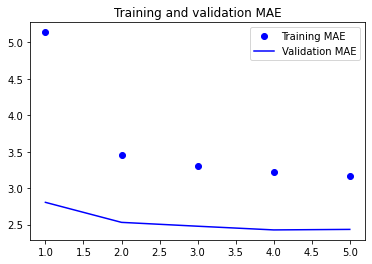

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [24]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.2, unroll=True)(inputs)

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 132s 157ms/step - loss: 26.2994 - mae: 3.7812 - val_loss: 9.3824 - val_mae: 2.3662
INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.x/assets


INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.x/assets


Epoch 2/5
819/819 [==============================] - 129s 157ms/step - loss: 14.0811 - mae: 2.9064 - val_loss: 8.9851 - val_mae: 2.3182
INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.x/assets


INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.x/assets


Epoch 3/5
819/819 [==============================] - 128s 156ms/step - loss: 13.2450 - mae: 2.8202 - val_loss: 9.1568 - val_mae: 2.3649
Epoch 4/5
819/819 [==============================] - 128s 156ms/step - loss: 12.6456 - mae: 2.7540 - val_loss: 10.1874 - val_mae: 2.4731
Epoch 5/5
405/405 [==============================] - 12s 27ms/step - loss: 10.2277 - mae: 2.5015
Test MAE: 2.50


In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/5
819/819 [==============================] - 48s 56ms/step - loss: 28.0323 - mae: 3.7962 - val_loss: 10.5247 - val_mae: 2.5177
Epoch 2/5
819/819 [==============================] - 46s 56ms/step - loss: 9.6537 - mae: 2.4298 - val_loss: 9.4190 - val_mae: 2.3834
Epoch 3/5
819/819 [==============================] - 46s 56ms/step - loss: 8.7137 - mae: 2.2978 - val_loss: 9.7158 - val_mae: 2.4290
Epoch 4/5
819/819 [==============================] - 44s 53ms/step - loss: 8.1463 - mae: 2.2195 - val_loss: 9.9234 - val_mae: 2.4450
Epoch 5/5
405/405 [==============================] - 7s 18ms/step - loss: 10.4592 - mae: 2.5345
Test MAE: 2.53


In [ ]:
combined = layers.concatenate([conv_x, lstm_x])
outputs = layers.Dense(1)(combined)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/5
819/819 [==============================] - 49s 57ms/step - loss: 7.4359 - mae: 2.1235 - val_loss: 10.4062 - val_mae: 2.4939
Epoch 2/5
819/819 [==============================] - 44s 54ms/step - loss: 7.1361 - mae: 2.0799 - val_loss: 10.4908 - val_mae: 2.4894
Epoch 3/5
819/819 [==============================] - 44s 54ms/step - loss: 6.8714 - mae: 2.0402 - val_loss: 10.6966 - val_mae: 2.5130
Epoch 4/5
530/819 [==================>...........] - ETA: 13s - loss: 6.7240 - mae: 2.0169

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()